# Костыра Екатерина Сергеевна ПМ1901

## 1. Построение модели SARIMAX

In [105]:
import numpy as np
import pandas as pd
from pandas import datetime
from itertools import product
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\41BC~1\AppData\Local\Temp/ipykernel_11276/3998230167.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [106]:
mcs = pd.read_csv('C:/Users/79811/anaconda3/7. monthly-champagne-sales-in-1000s (1).csv', index_col="Month", parse_dates=True)

In [107]:
pd.to_datetime(mcs.index.map(lambda x: '200'+x))

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01', '2001-11-01', '2001-12-01',
               '2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01',
               '2002-05-01', '2002-06-01', '2002-07-01', '2002-08-01',
               '2002-09-01', '2002-10-01', '2002-11-01', '2002-12-01',
               '2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01', '2003-11-01', '2003-12-01',
               '2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01', '2004-11-01', '2004-12-01',
               '2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01',
               '2005-05-01', '2005-06-01', '2005-07-01', '2005-08-01',
      

In [108]:
mcs.index = pd.to_datetime(mcs.index.map(lambda x: '200'+x))

In [109]:
mcs.columns = ['y1']

In [110]:
mcs.head()

,y1
Month,
2001-01-01,2851
2001-02-01,2672
2001-03-01,2755
2001-04-01,2721
2001-05-01,2946


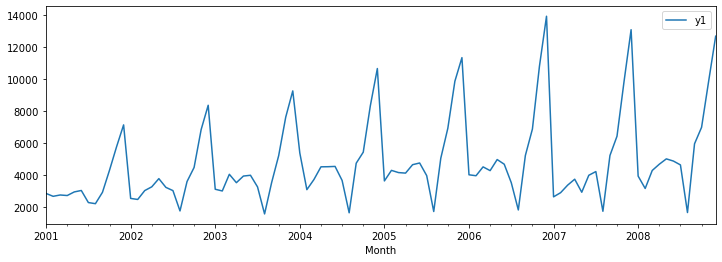

In [112]:
mcs.plot(figsize=(12,4))
plt.show()

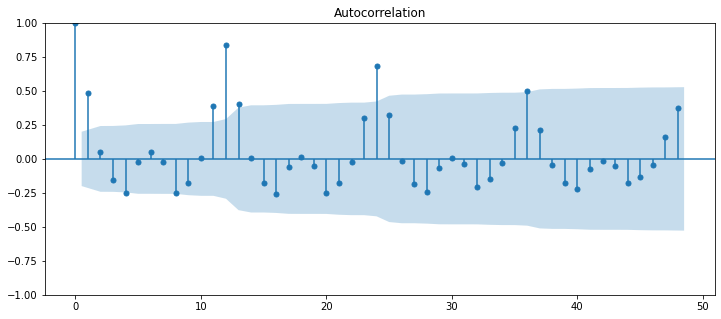

In [113]:
plt.rcParams["figure.figsize"] = (12,5)
plot_acf(mcs.dropna(), lags=48)
plt.show()

## 1.1. Стабилизация дисперсии

In [10]:
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

Оптимальный параметр преобразования Бокса-Кокса: -0.2366339880503088
Критерий Дики-Фуллера: p=0.32127784542158566


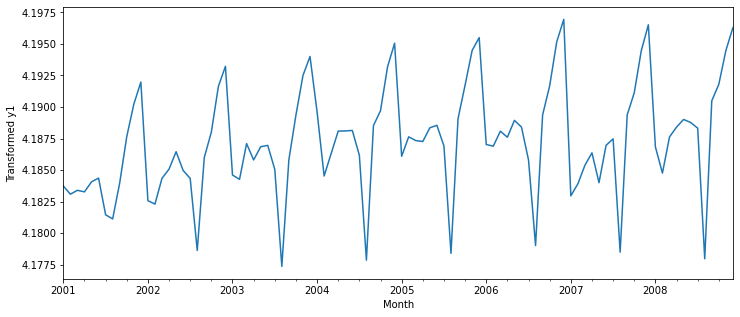

In [114]:
mcs["y1"] *= 100000
mcs["y1_box"], lmbda = boxcox(mcs["y1"])
mcs["y1_box"].plot(figsize=(12,5))
plt.ylabel("Transformed y1")
print(f"Оптимальный параметр преобразования Бокса-Кокса: {lmbda}")
print(f"Критерий Дики-Фуллера: p={adfuller(mcs['y1_box'])[1]}")

Очевидно наличие сезонности. Сезонность будет учтена во время построения модели SARIMAX, однако для определения порядков авторегресии и скользящего среднего для начала необходимо провести дифференцирование.

## 1.2. Дифференцирование ряда

Критерий Дики-Фуллера: p=0.0089834317228882


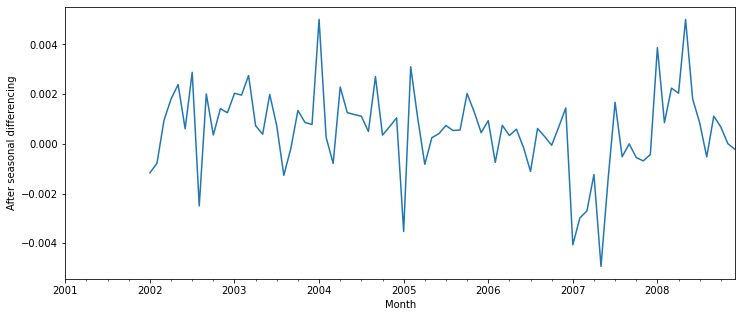

In [115]:
mcs["y1_box_sdiff"] = mcs["y1_box"].diff(12)
mcs["y1_box_sdiff"].plot(figsize=(12,5))
plt.ylabel("After seasonal differencing")
print(f"Критерий Дики-Фуллера: p={adfuller(mcs['y1_box_sdiff'].dropna())[1]}")

Можно заметить, что по критерию Дики-Фуллера ряд не является стационарным. Проведем обычное дифференцирование.

Критерий Дики-Фуллера: p=1.8828507866913607e-13


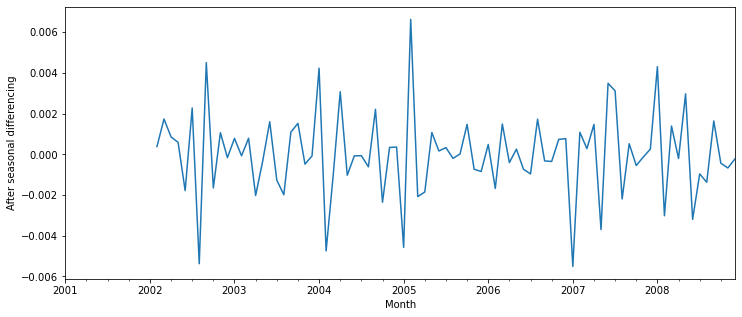

In [116]:
mcs["y1_box_diff"] = mcs["y1_box_sdiff"].diff(1)
mcs["y1_box_diff"].plot(figsize=(12,5))
plt.ylabel("After seasonal differencing")
print(f"Критерий Дики-Фуллера: p={adfuller(mcs['y1_box_diff'].dropna())[1]}")

## 1.3. Выбор гиперпараметров модели

Для выбора порядка скользящего среднего обратимся к коррелограмме.

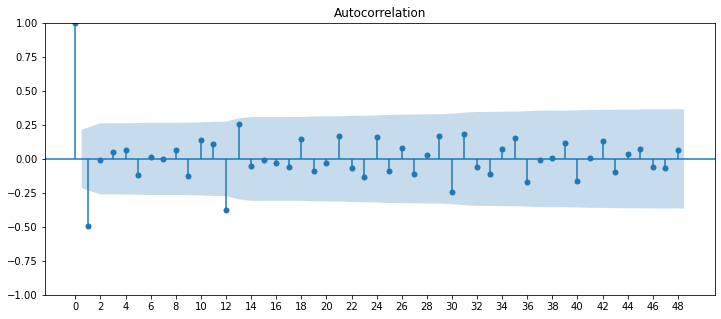

In [144]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(mcs['y1_box_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Посдедний значимый лаг равен 2. А последний значимый сезонный лаг равен 1 (при лаге 12 автокорреляция значима, при 24 – незначима). Таким образом,  𝑞0=2,𝑄0=1 .

Для выбора порядка авторегрессии обратимся к частичной автокорреляции.

C:\Users\79811\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


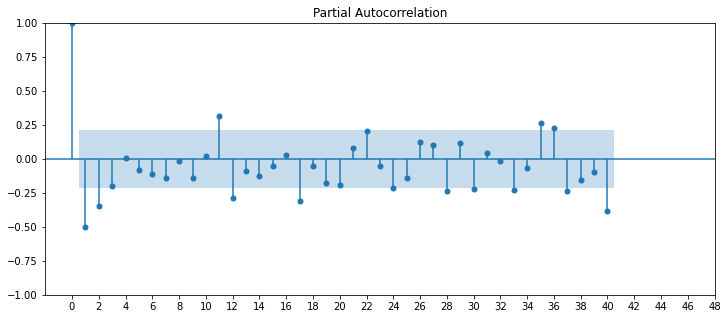

In [146]:
plt.rcParams["figure.figsize"] = (12,5)
plot_pacf(mcs["y1_box_diff"].dropna(), lags=40)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Последний значимый лаг оказался равным 4, значит  𝑝0=4 . Период сезонности составляет 12. При лаге, равном 12, частичная автокорреляция незначима, значит,  𝑃0=0 .

Таким образом, будем рассматривать следующие наборы гиперпараметров модели SARIMA:

In [147]:
d=1
D=1
p = range(0, 5)
q = range(0, 2)
P = range(0, 3)
Q = range(0, 2)

In [148]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

60

## 1.4. Выбор оптимальной модели

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [149]:
mcs.index.freq = 'MS'

In [122]:
results = []
best_aic = float('inf')

for params in parameters_list:
    try:
        model = SARIMAX(mcs["y1_box"],
                        order=(params[0], d, params[1]), 
                        seasonal_order=(params[2], D, params[3], 12)).fit()
    except ValueError:
        print("Wrong parameters:", param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = params
    results.append([params, model.aic])

C:\Users\79811\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\79811\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\79811\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\79811\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\79811\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

In [150]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())

      parameters         aic
8   (0, 1, 1, 0) -834.147680
7   (0, 1, 0, 1) -832.629340
20  (1, 1, 1, 0) -831.941998
19  (1, 1, 0, 1) -830.492883
9   (0, 1, 1, 1) -830.302500


## 1.5. Визуализация результата

Визуализируем лучшую полученную модель. Не забудем выполнить обратное преобразование Бокса-Кокса. Обратное дифференцирование будет выполнено функцией SARIMAX.

In [44]:
from scipy.special import inv_boxcox

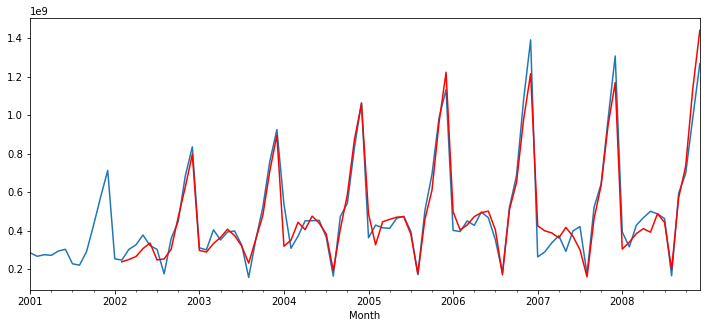

In [124]:
mcs['model'] = inv_boxcox(best_model.fittedvalues, lmbda)
mcs["y1"].plot(figsize=(12,5))
mcs.model[13:].plot(color='r')
plt.show()

In [125]:
start = mcs.index[-1] + pd.DateOffset(months=1)
end = start + pd.DateOffset(months=35)

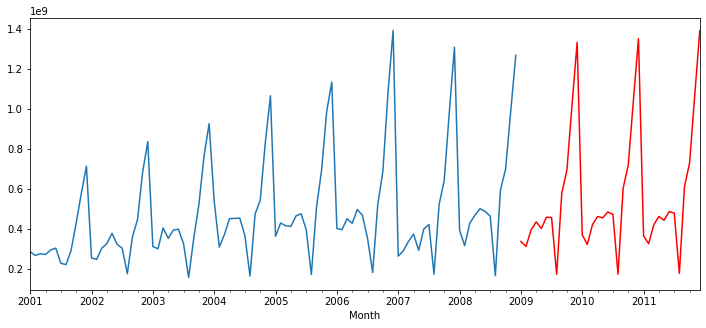

In [126]:
mcs['y1'].plot(figsize=(12,5))
inv_boxcox(best_model.predict(start=start, end=end), lmbda).plot(color='r')
plt.show()

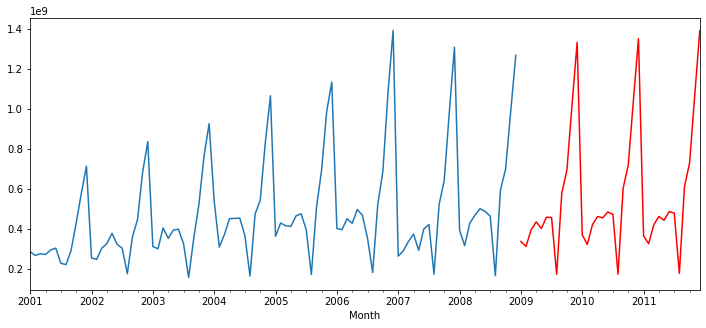

In [127]:
mcs["y1"].plot(figsize=(12,5))
inv_boxcox(best_model.forecast(36), lmbda).plot(color='r')
plt.show()

## 2. Модель Prophet

## 2.1. Инициализация и обучение модели

In [151]:
from fbprophet import Prophet

In [152]:
mcs.head()

,y1,y1_box,y1_box_sdiff,y1_box_diff,model
Month,,,,,
2001-01-01,285100000,4.183748,NaN,NaN,1.000000e+00
2001-02-01,267200000,4.183096,NaN,NaN,2.851000e+08
2001-03-01,275500000,4.183405,NaN,NaN,2.672000e+08
2001-04-01,272100000,4.183280,NaN,NaN,2.755000e+08
2001-05-01,294600000,4.184074,NaN,NaN,2.721000e+08


In [153]:
mcs_prophet = mcs[['y1_box']]
mcs_prophet = mcs_prophet.reset_index()
mcs_prophet.columns = ['ds', 'y']

In [154]:
mcs_prophet.head()

,ds,y
0,2001-01-01,4.183748
1,2001-02-01,4.183096
2,2001-03-01,4.183405
3,2001-04-01,4.183280
4,2001-05-01,4.184074


In [131]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False)
model.fit(mcs_prophet)

C:\Users\79811\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


## Прогноз

In [155]:
future = model.make_future_dataframe(periods=36, freq='MS')

Аппроксимацию построенной моделью и прогноз теперь можно получить с помощью функции predict, которая вернет pd.DataFrame с результатами.

In [156]:
forecast = model.predict(future)

C:\Users\79811\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\79811\anaconda3\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Приведем оценки модели и прогнозный интервал для последних 12 спрогнозированных значений:

In [159]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
120,2011-01-01,4.190982,4.163771,4.219996
121,2011-02-01,4.189749,4.161147,4.220063
122,2011-03-01,4.192407,4.162228,4.224725
123,2011-04-01,4.191995,4.158857,4.226752
124,2011-05-01,4.192265,4.157947,4.228924
125,2011-06-01,4.193057,4.156862,4.231424
126,2011-07-01,4.191980,4.154396,4.231982
127,2011-08-01,4.184954,4.146089,4.228441
128,2011-09-01,4.193517,4.151824,4.238666
129,2011-10-01,4.196292,4.151881,4.243334


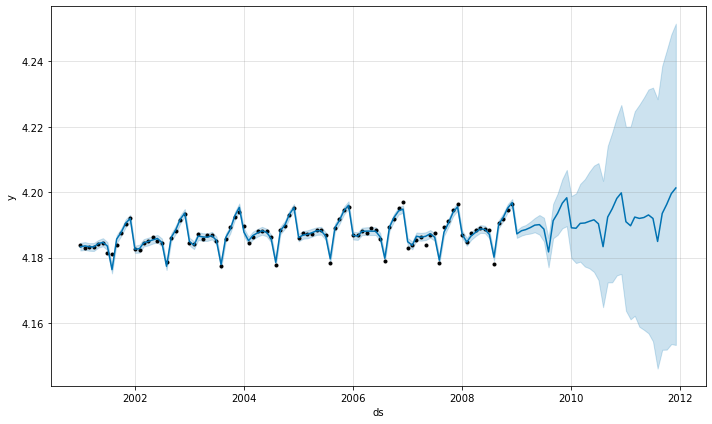

In [160]:
model.plot(forecast)
plt.show()

## 3. Сравнение Prophet и SARIMAX

In [96]:
from statsmodels.tools.eval_measures import mse

In [136]:
mse_prophet = mse(mcs["y1"], forecast.loc[:, "yhat"][:-36])
print(mse_prophet)

2.9957333691407046e+17


In [137]:
mse_statsmodels = mse(mcs["y1"], mcs["model"])
print(mse_statsmodels)

nan
